In [5]:
require 'nn'
require 'image' --necessary?
require 'unsup'
require("lfwMCMCUpdatesFunction")
require("lfwCDBNModelBuilderFunction")
require("freeEnergy")
require("parameterInitialiserFunction")
-- spatialConvolution only seems to be able to process one image ata ie (i.e. expects a 3D tensor only)
-- Constant step size for hiddenBias updates?

In [68]:
package.loaded["parameterInitialiserFunction"] = nil

In [6]:
model = CDBNModelBuilder(2,{3,3},{32,64},{10,10})
--model = CDBNModelBuilder(2,{3,3},{32,64},{15,10})

In [8]:
    --model:get(1).bias

In [9]:
testReadFile = torch.DiskFile('lfwDataSetShort.foo', 'r')
testRead = testReadFile:readObject()

In [10]:
--trainingData = image.scale(testRead[{{1,20},{},{}}],100,100)
--collectgarbage("count")
trainingData = image.scale(testRead,100,100)

In [13]:
--trainingData:size()

In [11]:
index = 1
--baseLayer = trainingData[{{1},{},{}}]
--model:forward(baseLayer)
--visLayer = model:get(6).output
--visLayer = trainingData[{{1},{},{}}]

--visLayerSet = torch.Tensor(trainingData:size()[1],1,100,100)
--for i = 1,trainingData:size()[1] do
    --visLayerSet[i]=trainingData[{{i},{},{}}]
--end

visLayerSet = torch.Tensor(142,1,100,100)
for i = 1,142 do
    visLayerSet[i]=trainingData[{{i},{},{}}]
end

In [6]:
freeEnergyStore3 = torch.Tensor(1000):fill(0)
activationsStore2 = torch.Tensor(1000):fill(0)

In [63]:
--freeEnergyStore2:size()


 200
[torch.LongStorage of size 1]



In [14]:
testReadFile = torch.DiskFile('preNorm10by10/filterWeightsCopy2pN.foo', 'r')
filterWeights = testReadFile:readObject()
testReadFile = torch.DiskFile('preNorm10by10/hiddenBiasCopy2pN.foo', 'r')
hiddenBias = testReadFile:readObject()
testReadFile = torch.DiskFile('preNorm10by10/visBiasCopy2pN.foo', 'r')
visBias = testReadFile:readObject()

In [43]:
for i = 1,100 do
    freeEnergyStore2[i] = freeEnergyStore[i]
end

In [15]:
--Tweak learningRate, but what is comforting about learningRate = {0.0001,0.01,0.001} is that the 
--  distances no longer spiral out of control in a non-convergence type way.
learningRate = {0.1,0.1,0.1} 
sparsityPenalty=0.01
sparsityRate = 0.8
convergenceThreshold = 0.0001


In [16]:
j = 0

In [17]:
visLayerSet:size()


 142
   1
 100
 100
[torch.LongStorage of size 4]



In [18]:
    --variable setup---
    convergenceFlag = 0
    repeatCounter = 0
    --predeclaring the memory to be used.
    --hiddenTensor = torch.Tensor(model:get(index).output:size())
    hiddenTensor = model:get(index):forward(visLayerSet[1])


In [19]:
    --Nh,K,Vl,Nw,Nv,visBias
    N = visLayerSet:size()[1]
    K = hiddenTensor:size()[1]
    Vl = visLayerSet[1]:size()[1]
    
    Nh = hiddenTensor:size()[2]
    Nv = visLayerSet[1]:size()[2]
    Nw = model:get(index).weight:size()[3]
    --/variable setup---
    
    --INITIALISATION STEP. --Here we will need to initialise the filters using the K-Means/Gaussian EM thing.
    --filterWeights = model:get(index).weight
    --hiddenBias = model:get(index).bias --Note that these create a reference, not a clone, so altering
        --either filterWeights or hiddenBias will also alter the model's parameters too.
    --visBias = torch.Tensor(Vl):fill(0)
    
    --filterWeights, hiddenBias, visBias = parameterInitialiser(visLayerSet,K,Vl,Nv,N,Nw)
    
    --/INITIALISATION STEP.
    
    --PRECALLING OF FUNCTIONS---
    --gradFilterConv will be used in the parameter updates step, specifically to update the filters. Since
    --  the weight is tied to the hiddenTensor and NOT CLONED we should be able to update the convolution
    --  without having to constantly redeclare the convolution

    gradFilterConv = nn.SpatialConvolution(1,K,Nh,Nh)
    gradFilterConv.bias = torch.Tensor(K):fill(0)
    
  
    --origSampleFilterWeightDifferential used as the base from which the filter weights CD gradient is 
    --    approximated; the summation convolution with the original training data sample
    origSampleFilterWeightDifferential = torch.Tensor(Vl,K,Nw,Nw) --??? Should work hopefully ???

    --/PRECALLING OF FUNCTIONS---

In [20]:
    while (repeatCounter < (142*0+1)) do
        repeatCounter = repeatCounter + 1
        
        
    
        --*********************************************************************
        --switch visible image being considered -- REJIG HIDDEN TENSOR STUFF.
        --*********************************************************************
        
        --MCMC UPDATES STEP - can expand this for CD-k, but for the moment just using CD-1
        --gibbsHiddenUpdate
        visLayer = visLayerSet[(repeatCounter-1)%N +1]
        hiddenTensor = model:get(index):forward(visLayer)
        hiddenTensor, origProbTensor =  gibbsHiddenUpdate(Nh,K,Nw,hiddenTensor)
        
        --origHiddenTensorClone = hiddenTensor:clone()
        --probTensor = torch.Tensor(hiddenTensor:size())
        --so that we don't interfere with memory outside of the function we will create a clone of the visLayer
        visLayerClone = torch.Tensor(visLayer:size())
        gradFilterConv.weight[{{},{1},{},{}}] = origProbTensor
        for l = 1,Vl do
            origSampleFilterWeightDifferential[l] = gradFilterConv:forward(visLayer[{{l},{},{}}]) --???? Hope this works
        end  
        
        if index == 1 then
            -- Real Visible Layer 
            visLayerClone = gibbsRealVisibleUpdate(model,index,Nv,K,Vl,Nw,visBias,hiddenTensor)
        
        else 
            -- Binary Visible Layer
            visLayerClone = gibbsBinaryVisibleUpdate(model,index,Nv,K,Vl,Nw,visBias,hiddenTensor)
            
        end
        
        --Another MCMC updates step  for weights updates step.
        hiddenTensor, probTensor =  gibbsHiddenUpdate(Nh,K,Nw,hiddenTensor)
        --/MCMC UPDATES STEP.
        
        --Update weights and biases using the CD approximation---
        --learningRate will pop up here
        
        fWCopy = filterWeights:clone()
        hBCopy = hiddenBias:clone()
        vBCopy = visBias:clone()

        --filter weight updates
        newSampleFWDiff = torch.Tensor(Vl,K,Nw,Nw)
        gradFilterConv.weight[{{},{1},{},{}}] = probTensor
        for l = 1,Vl do 
          newSampleFWDiff[l] = gradFilterConv:forward(visLayerClone[{{l},{},{}}]) 
        end
        filterWeights:add(learningRate[1]/(Nh*Nh),origSampleFilterWeightDifferential:add(-1,newSampleFWDiff)) 
        
        --hidden Bias Updates
        --  Without Sparsity
        --hiddenBias:add(learningRate,origHiddenTensorClone:sum(2):sum(3):add(-1,origHiddenTensorClone:sum(2):sum(3)))
        --  With Sparsity
        --hiddenBias:add(learningRate[2]/(Nh*Nh),origProbTensor:sum(2):sum(3):add(-1,probTensor:sum(2):sum(3)))
        
        --uses the probTensor in 
        --sparsityPenaltyAddition = torch.Tensor(K):fill(sparsityPenalty):add(-1/(Nh*Nh),probTensor:sum(2):sum(3))        
        --hiddenBias:add(learningRate[2],sparsityPenaltyAddition)
        
        hiddenBias:add(learningRate[2]/(Nh*Nh),origProbTensor:sum(2):sum(3):add(-(1+sparsityRate),probTensor:sum(2):sum(3)))
        
        --uses the probTensor in 
        sparsityPenaltyAddition = torch.Tensor(K):fill(sparsityPenalty)       
        hiddenBias:add(learningRate[2]*sparsityRate,sparsityPenaltyAddition)
        
        --visible Bias Updates
        visBias:add(learningRate[3]/(Nv*Nv),  visLayer:sum(2):sum(3):add(-1,visLayerClone:sum(2):sum(3))   )
        
        --/Update weights and biases using the CD approximation---
        
        --if(torch.dist(visBias,vBCopy)+torch.dist(hiddenBias,hBCopy)+torch.dist(fWCopy,filterWeights) < convergenceThreshold ) then 
            --convergenceFlag = 1
        --end
        --calculate convergenceDistance and see whether to terminate process or keep going.
        collectgarbage("collect")
    
            if(repeatCounter%50 == 0) then
                print(repeatCounter)
                --printing average hidden activations
                --print(probTensor:sum(1):sum(2):sum(3):storage()[1]/(K*Nh*Nh))
            end
            if(repeatCounter%142 == 0) then
                
                --freeEnergy = freeEnergy(model,index,visLayerSet[{{1,20},{},{},{}}],visBias,Nh,K,Nw)
                j = j + 1
                print("epoch End: " .. j)
        --freeEnergyAndAverageActivations(...)
                --freeEnergyStore2[j],activationsStore[j] = freeEnergyAndAverageActivations(model,index,visLayerSet[{{1,142},{},{},{}}],visBias,Nh,K,Nw)
                --print(freeEnergyStore2[j])
                --print(activationsStore[j])
                freeEnergyStore3[j] = freeEnergy(model,index,visLayerSet[{{1,142},{},{},{}}],visBias,Nh,K,Nw)
                print(freeEnergyStore3[j])
                print(torch.dist(visBias,vBCopy))
                print(torch.dist(hiddenBias,hBCopy))
                print(torch.dist(fWCopy,filterWeights))
                    --calculate convergenceDistance and see whether to terminate process or keep going.
                print(collectgarbage("count") .." MegaBytes used" )
            end
    end
    
    --At this point the weights and hiddenBias and visBias should have been learned.
    

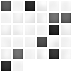

In [21]:
itorch.image(filterWeights)

In [83]:
--freeEnergyStore2[2] = freeEnergyStore2[22] 
--j = 2

In [82]:
--filterWeights

In [97]:
bla = torch.Tensor(filterWeights:size())
for i = 1,K do
bla[i] = image.minmax{tensor =filterWeights[i]}
end

In [163]:
bla = image.minmax{tensor =filterWeights}

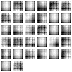

In [98]:
itorch.image(bla)

In [63]:
--filterWeights[1]

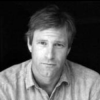

In [22]:
itorch.image(visLayer)

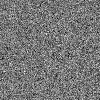

In [23]:
itorch.image(image.minmax{tensor = visLayerClone}) --after 143 iterations the results are surprisingly ok from base initialisations

In [139]:
--visLayerClone

In [99]:
--file = torch.DiskFile('filterWeightsCopy1000Epochs.foo', 'w')
--file:writeObject(filterWeights)
--file:close()

In [100]:
--file = torch.DiskFile('visBiasCopy1000Epochs.foo', 'w')
--file:writeObject(visBias)
--file:close()

In [101]:
--file = torch.DiskFile('hiddenBiasCopy1000Epochs.foo', 'w')
--file:writeObject(hiddenBias)
--file:close()

In [62]:
cumulativeFreeEnergy

10211.311952061	


In [48]:
visBiasFE = visBias
dataSet= visLayerSet[{{1,20},{},{},{}}]

In [51]:

    visClone = dataSet:clone()
    visClone2 = dataSet:clone()
    cumulativeFreeEnergy = 0
    
    N = dataSet:size()[1]


In [18]:
        
    for i = 1,N do
   end

20	


In [52]:
i = 1

In [53]:
        --In each loop iteration we add up the ith image's contribution to the FreeEnergy
        modelOutput = model:get(index):forward(visClone[i])
        dummyTensor, posteriorTensor = gibbsHiddenUpdate(Nh,K,Nw,modelOutput)


In [55]:
        
        --dummyTensor a dummy variable at the moment, but if we do decide to use the sample hidden activations
        --  then dummyTensor has these available. posteriorTensor we will use in calculating the energy
        
        --At this point, modelOutput should be a KxNhxNh tensor, as should posteriorTensor
        --  so just need to element-wise multiply the tensors, then sum along the first, second and third 
        --  dimension.
        
        cumulativeFreeEnergy = cumulativeFreeEnergy - modelOutput:cmul(posteriorTensor):sum(1):sum(2):sum(3):storage()[1]


In [56]:
                        
        --Now need to account for the energy contributions of the visible parts alone
            cumulativeFreeEnergy = cumulativeFreeEnergy + visClone[i]:pow(2):sum(1):sum(2):sum(3):storage()[1]/2 - visClone2[i]:sum(2):sum(3):cmul(visBiasFE):sum(1):storage()[1]
 

In [29]:
modelOutput:cmul(posteriorTensor):sum(1):sum(2):sum(3):storage()[1]

0	


In [31]:
                        
        --Now need to account for the energy contributions of the visible parts alone
        cumulativeFreeEnergy = cumulativeFreeEnergy + dataSet[i]:pow(2):sum(1):sum(2):sum(3)/2 - dataSet[i]:sum(2):sum(3):cmul(visBiasFE):sum(1)
    --end

[string "                        ..."]:3: internal error in __add: no metatable
stack traceback:
	[C]: in function '__add'
	[string "                        ..."]:3: in main chunk
	[C]: in function 'xpcall'
	/usr/local/share/lua/5.1/itorch/main.lua:177: in function </usr/local/share/lua/5.1/itorch/main.lua:143>
	/usr/local/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/usr/local/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/usr/local/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/usr/local/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/usr/local/share/lua/5.1/itorch/main.lua:344: in main chunk
	[C]: in function 'require'
	[string "arg={'/home/yingtone/.ipython/profile_default..."]:1: in main chunk: 

In [39]:
dataSet[i]:pow(2):sum(1):sum(2):sum(3)

(1,.,.) = 
 1e-57 *
   5.1646
[torch.DoubleTensor of size 1x1x1]



In [64]:
freeEnergy = nil

In [4]:
trainingData

In [24]:
testHiddenTensor = visLayerSet[{{1,2},{},{},{}}]

In [25]:
Nv = 5
K = 2
Vl = 2
Nw = 2
visBias = torch.Tensor(2)
visBias[1] = 0.2
visBias[2] = 0.4
NumBatch = 2
index = 1

In [26]:
model = CDBNModelBuilder(2,{2,2},{32,64},{2,2})

In [27]:
visSet = torch.Tensor(2,2,5,5)

In [28]:
for i = 1,100 do 
    visSet:storage()[i] = i
end

In [29]:
visSet

(1,1,.,.) = 
    1    2    3    4    5
    6    7    8    9   10
   11   12   13   14   15
   16   17   18   19   20
   21   22   23   24   25

(2,1,.,.) = 
   51   52   53   54   55
   56   57   58   59   60
   61   62   63   64   65
   66   67   68   69   70
   71   72   73   74   75

(1,2,.,.) = 
   26   27   28   29   30
   31   32   33   34   35
   36   37   38   39   40
   41   42   43   44   45
   46   47   48   49   50

(2,2,.,.) = 
   76   77   78   79   80
   81   82   83   84   85
   86   87   88   89   90
   91   92   93   94   95
   96   97   98   99  100
[torch.DoubleTensor of size 2x2x5x5]



In [ ]:
hidTest = model:get(index):forward(visSet[1])

In [ ]:
89

In [ ]:
function gibbsRealVisibleUpdate(model,index,Nv,K,Vl,Nw,NumBatch,visBias,hiddenNodeTensor)
  -- cap proposals? Currently it can propose visible values outside 0 and 1 which doesn't agree with the orig. image
  --Expects hiddenNodeTensor to be a NumBatchxKxNhxNh tensor
  local visConv = nn.SpatialConvolutionMM(K,Vl,Nw,Nw,1,1,Nw-1,Nw-1) 
  visConv.weight = model:get(index).weight
  visConv.weight = image.flip(visConv.weight,3)
  visConv.weight = image.flip(visConv.weight,4)
  visConv.weight:transpose(1,2)
  visConv.bias = visBias
  return visConv:forward(hiddenNodeTensor) + torch.randn(NumBatch,Vl,Nv,Nv)
end

function gibbsBinaryVisibleUpdate(model,index,Nv,K,Vl,Nw,NumBatch,visBias,hiddenNodeTensor)
  --Expects hiddenNodeTensor to be a NumBatchxKxNhxNh tensor 
  local visConv = nn.SpatialConvolutionMM(K,Vl,Nw,Nw,1,1,Nw-1,Nw-1) 
  --  Need to Import filter parameters here. Need to swap first and second dimensions (input to output planes)
  visConv.weight = model:get(index).weight
  visConv.weight = image.flip(visConv.weight,3) --Re-ordered flip to prevent contiguous error flip
  visConv.weight = image.flip(visConv.weight,4)
  visConv.weight:transpose(1,2) --swaps first and second dimension i.e. input and 
    --output planes as necessary
  visConv.bias = visBias
  --meanTensor = visConv:forward(hiddenNodeTensor)
  local probVTensor = nn.Sigmoid():forward(visConv:forward(hiddenNodeTensor)) --Gets the probability of visible node being active
  --unifProbs = torch.rand(Vl,Nv,Nv) --Needs to be a numVisPlanesxNvxNv uniform probability tensor
  --visibleNodeTensor = torch.le(unifProbs,probTensor):double()
  return torch.le(torch.rand(NumBatch,Vl,Nv,Nv),probVTensor):double()
end

function gibbsHiddenUpdate(Nh,K,Nw,NumBatch,hiddenNodeTensor)
  --Expects hiddenNodeTensor to be a NumBatchxKxNhxNh tensor   
  local numeTensor = hiddenNodeTensor:exp() --assuming that hiddenNodeTensor has already been calculated.
    --Want to keep this function as fast as possible. If needed though can pull the model into this function
  local sumDenomConv = nn.SpatialConvolutionMM(1,1,Nw,Nw,Nw,Nw)
  sumDenomConv.weight = torch.ones(1,1,Nw,Nw) --After each forward we have the inputs for the i'th filter as per
--    the for loop
  sumDenomConv.bias = torch.Tensor(1):fill(1)
  local sumNumeTensor = nn.SpatialZeroPadding(0,Nw-Nh%Nw,0,Nw-Nh%Nw):forward(numeTensor) -- pads so that we get
    --proper addition of all possible hidden node values; getting around SpatialConvolution quirks.
    --Also SpatialZeroPadding still works with the 4D tensors!
  local denomTensor = torch.Tensor(sumNumeTensor:size())

  --At this point sumNumeTensor should be a numBatchxKxNh+??xNh+??.
  --  So, when we iterate through the next for loop we iterate through the SECOND dimension. spatConvMM can do batch processing

  for i = 1,K do
  --first for loop loops through the hidden loop
      local contractDenomTensor = sumDenomConv:forward(sumNumeTensor[{{},{i},{},{}}]) -- is a 1x(Nh/Nw)x(Nh/Nw) tensor
        --Below expands out the tensor to the correct size
      denomTensor[{{},{i},{},{}}] = sumDenomConv:backward(sumNumeTensor[{{},{i},{},{}}],contractDenomTensor)
  end
  local probTensor = numeTensor:cdiv(denomTensor[{{},{},{1,Nh},{1,Nh}}])
  --unifProbs = torch.rand(K,Nh,Nh)
  --hiddenNodeTensor = torch.le(unifProbs,probTensor):double() --This bit activates the relevant units.
  return torch.le(torch.rand(K,Nh,Nh),probTensor):double(), probTensor
end
